## Twitter Setiment Analysis 

### Part 3: Quickly Train and Evaluate Several Models

The usual data-science workflow is to quickly train and evaluate several models before any further work (such as feature extraction) and with no hyperparameter tuning to select a few choice models for further work.

Since I'm running the project on a home laptop and have limited time, I also resort to trainining samples of the 1.6M dataset - for cases such as the slow-training SVM classifier.

Lastly, testing every possible method of vectorizing text would also take too long, so I'll have to use common sense and rely on a bit of luck.

### Load Pre-Processed Data

The timer decorator comes from Geir Arne Hjelle's [Real Python Tutorial](https://realpython.com/python-timer/#using-the-python-timer-decorator).

In [1]:
import os 
import time
import functools
import numpy as np
import scipy.sparse as sp

def timer(func):
    @functools.wraps(func)
    def wrapper_timer(*args, **kwargs):
        tic = time.perf_counter()
        value = func(*args, **kwargs)
        toc = time.perf_counter()
        elapsed_time = toc - tic
        print(f"Elapsed time: {elapsed_time:0.4f} seconds")
        return value
    return wrapper_timer

In [2]:
dirpath = os.path.join("..","data","3_processed","sentiment140")
filenames = ['X_text_bow'
            ,'X_tokn_bow'
            ,'X_filt_bow'
            ,'X_stem_bow'
            ,'X_text_tfidf'
            ,'X_tokn_tfidf'
            ,'X_filt_tfidf'
            ,'X_stem_tfidf'
            ,'X_text_log_tfidf'
            ,'X_tokn_log_tfidf'
            ,'X_filt_log_tfidf'
            ,'X_stem_log_tfidf']

filepaths = [os.path.join(dirpath, ''.join([filename, '.npz'])) for filename in filenames]

In [3]:
# load pre-processed featre vectors
@timer
def load_data():
    X_text_bow       = sp.load_npz(filepaths[0])
    X_tokn_bow       = sp.load_npz(filepaths[1])
    X_filt_bow       = sp.load_npz(filepaths[2])
    X_stem_bow       = sp.load_npz(filepaths[3])
    X_text_tfidf     = sp.load_npz(filepaths[4])
    X_tokn_tfidf     = sp.load_npz(filepaths[5])
    X_filt_tfidf     = sp.load_npz(filepaths[6])
    X_stem_tfidf     = sp.load_npz(filepaths[7])
    X_text_log_tfidf = sp.load_npz(filepaths[8])
    X_tokn_log_tfidf = sp.load_npz(filepaths[9])
    X_filt_log_tfidf = sp.load_npz(filepaths[10])
    X_stem_log_tfidf = sp.load_npz(filepaths[11])
    
    return (  X_text_bow      
            , X_tokn_bow      
            , X_filt_bow      
            , X_stem_bow      
            , X_text_tfidf    
            , X_tokn_tfidf    
            , X_filt_tfidf    
            , X_stem_tfidf    
            , X_text_log_tfidf
            , X_tokn_log_tfidf
            , X_filt_log_tfidf
            , X_stem_log_tfidf
            )

In [4]:
( X_text_bow      
, X_tokn_bow      
, X_filt_bow      
, X_stem_bow      
, X_text_tfidf    
, X_tokn_tfidf    
, X_filt_tfidf    
, X_stem_tfidf    
, X_text_log_tfidf
, X_tokn_log_tfidf
, X_filt_log_tfidf
, X_stem_log_tfidf
) = load_data()

Elapsed time: 27.7401 seconds


In [5]:
# load y target vector
y = np.load(os.path.join(dirpath, 'y.npy'))

---

### Train Classifiers

In [6]:
from sklearn.utils.random import sample_without_replacement

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve

import matplotlib.pyplot as plt

In [7]:
%matplotlib inline

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.xlabel("Threshold", fontsize=16)
    plt.legend(loc="upper left", fontsize=16)
    plt.ylim([0, 1])
    
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])
    
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)

In [8]:
X_text_bow.shape, round(X_text_bow.shape[0]/50, 0)

((1565200, 682281), 31304.0)

### Naive Bayes

In [9]:
# instantiate classifier
NB_clf = MultinomialNB()

Since the NB classifier is fast, we can perform CV across the entire dataset.

In [10]:
@timer
def plot_cvresults(clf, X, y, Xname, cv=5, scoring='accuracy', ylim=[.7, .8]):
    """Line plot of CV results for a given metric, given:
           clf: pre-trained classifier
           X: sparse matrix of features
           y: target vector
           Xname: name of sparse matrix for title
           cv: number of cv folds
           scoring: evaluation metric
                    see sklearn.metrics.SCORERS.keys()
           ylim: range for y-axis limits
    """
    cv_res = cross_val_score(clf, X, y, cv=cv, scoring=scoring)
    mn_res = np.mean(cv_res)

    fig = plt.figure(figsize=(8, 4))
    xs = []
    for x in range(cv):
        xs.append(str(x+1))
    plt.plot(xs, cv_res, 'b--', linewidth=.8, label=scoring)
    plt.axhline(y=mn_res, color='r', linestyle='-', linewidth=.5, 
                label=' '.join(["mean",scoring]))
    plt.title(''.join(["CV results - ", Xname]), fontsize=16)
    plt.xlabel("CV folds", fontsize=14)
    plt.ylabel(scoring, fontsize=14)
    plt.legend(loc="lower right", fontsize=14)
    plt.ylim(ylim)
    plt.show()

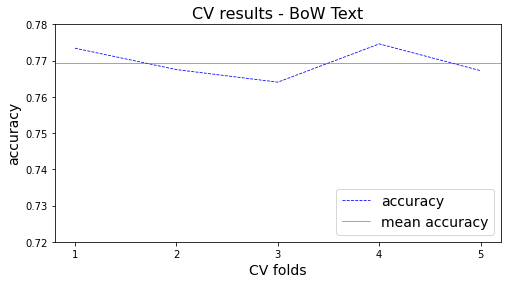

Elapsed time: 8.7765 seconds


In [11]:
plot_cvresults(NB_clf, X_text_bow, y, 'BoW Text', ylim=[.72,.78])

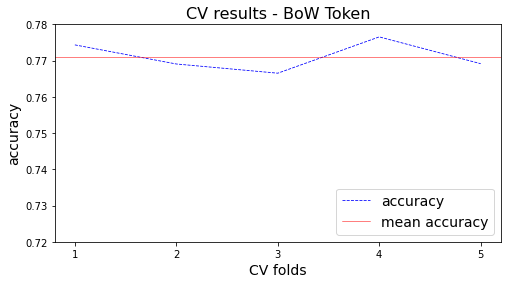

Elapsed time: 7.0005 seconds


In [12]:
plot_cvresults(NB_clf, X_tokn_bow, y, 'BoW Token', ylim=[.72,.78])

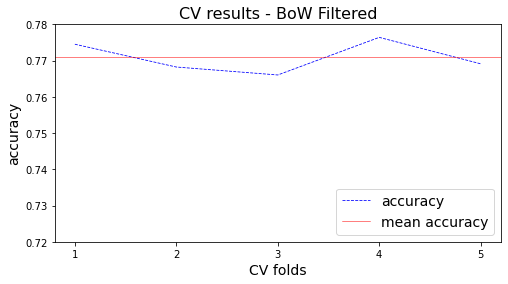

Elapsed time: 6.2926 seconds


In [13]:
plot_cvresults(NB_clf, X_filt_bow, y, 'BoW Filtered', ylim=[.72,.78])

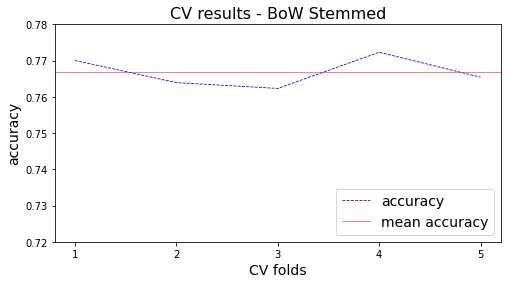

Elapsed time: 6.3257 seconds


In [14]:
plot_cvresults(NB_clf, X_stem_bow, y, 'BoW Stemmed', ylim=[.72,.78])

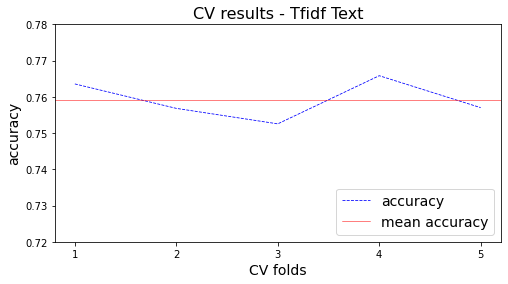

Elapsed time: 6.0998 seconds


In [15]:
plot_cvresults(NB_clf, X_text_tfidf, y, 'Tfidf Text', ylim=[.72,.78])

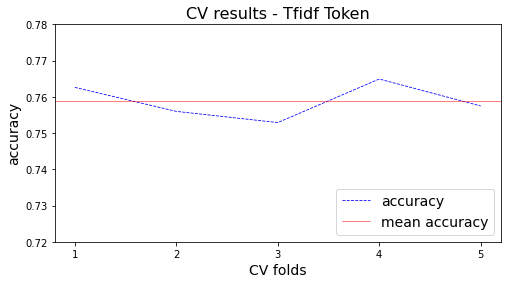

Elapsed time: 5.5087 seconds


In [16]:
plot_cvresults(NB_clf, X_tokn_tfidf, y, 'Tfidf Token', ylim=[.72,.78])

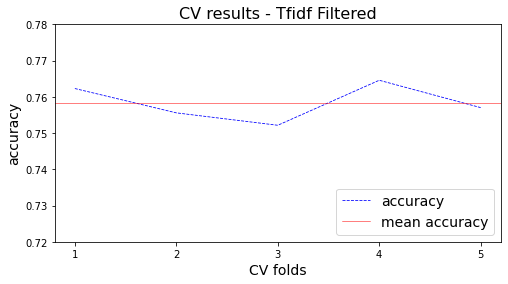

Elapsed time: 6.5638 seconds


In [17]:
plot_cvresults(NB_clf, X_filt_tfidf, y, 'Tfidf Filtered', ylim=[.72,.78])

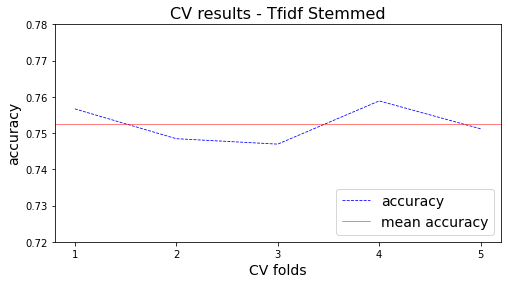

Elapsed time: 6.2103 seconds


In [18]:
plot_cvresults(NB_clf, X_stem_tfidf, y, 'Tfidf Stemmed', ylim=[.72,.78])

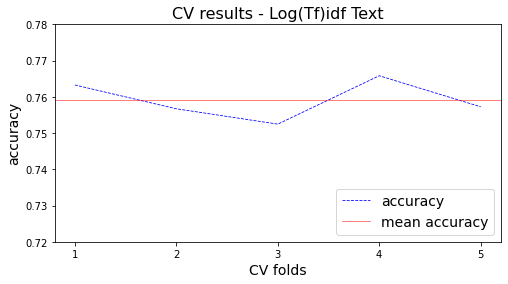

Elapsed time: 6.4252 seconds


In [19]:
plot_cvresults(NB_clf, X_text_log_tfidf, y, 'Log(Tf)idf Text', ylim=[.72,.78])

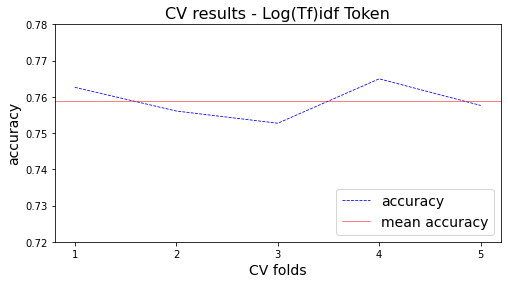

Elapsed time: 6.4661 seconds


In [20]:
plot_cvresults(NB_clf, X_tokn_log_tfidf, y, 'Log(Tf)idf Token', ylim=[.72,.78])

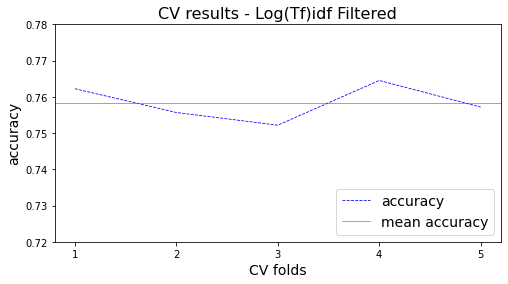

Elapsed time: 6.0133 seconds


In [21]:
plot_cvresults(NB_clf, X_filt_log_tfidf, y, 'Log(Tf)idf Filtered', ylim=[.72,.78])

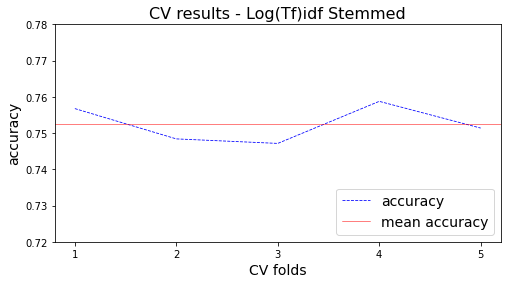

Elapsed time: 6.7129 seconds


In [22]:
plot_cvresults(NB_clf, X_stem_log_tfidf, y, 'Log(Tf)idf Stemmed', ylim=[.72,.78])

#### Preliminary Assessment

As far as accuracy is concerned, BoW performs better than Tfidf, and the tokenized and filtered versions are faster and more accurate.

Looking at `recall`:

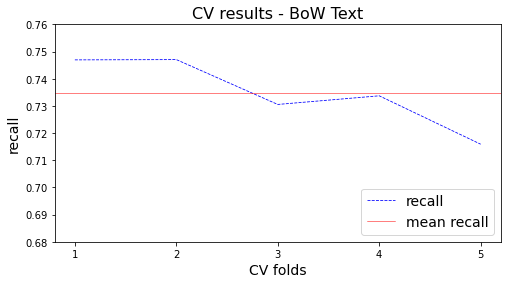

Elapsed time: 7.5919 seconds


In [23]:
plot_cvresults(NB_clf, X_text_bow, y, 'BoW Text', scoring='recall', ylim=[.68,.76])

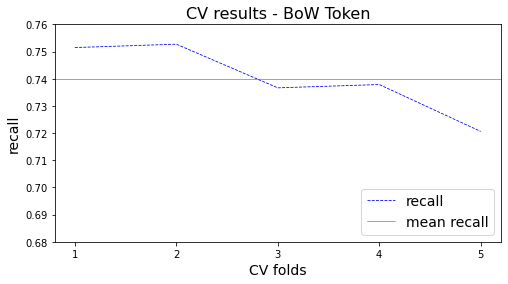

Elapsed time: 7.2064 seconds


In [24]:
plot_cvresults(NB_clf, X_tokn_bow, y, 'BoW Token', scoring='recall', ylim=[.68,.76])

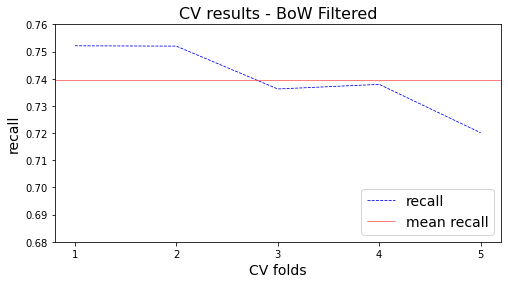

Elapsed time: 6.6491 seconds


In [25]:
plot_cvresults(NB_clf, X_filt_bow, y, 'BoW Filtered', scoring='recall', ylim=[.68,.76])

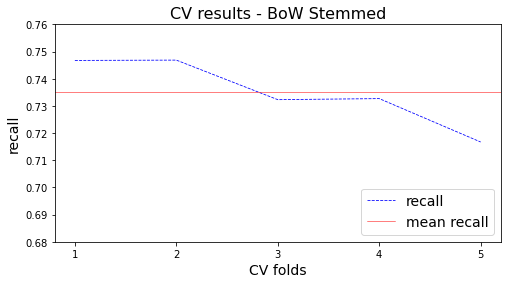

Elapsed time: 7.1931 seconds


In [26]:
plot_cvresults(NB_clf, X_stem_bow, y, 'BoW Stemmed', scoring='recall', ylim=[.68,.76])

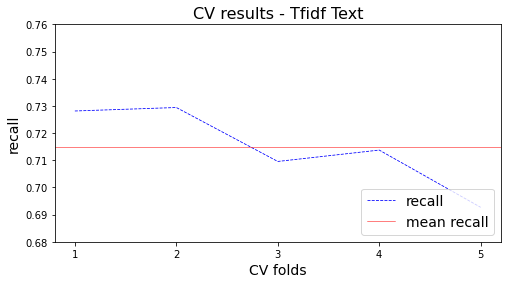

Elapsed time: 7.6725 seconds


In [27]:
plot_cvresults(NB_clf, X_text_tfidf, y, 'Tfidf Text', scoring='recall', ylim=[.68,.76])

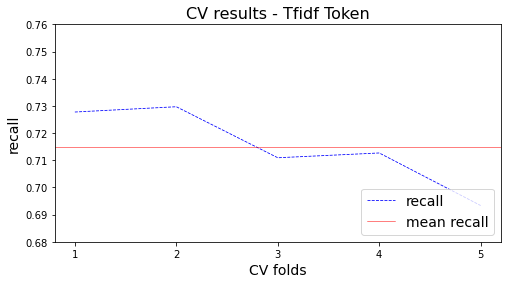

Elapsed time: 7.7808 seconds


In [28]:
plot_cvresults(NB_clf, X_tokn_tfidf, y, 'Tfidf Token', scoring='recall', ylim=[.68,.76])

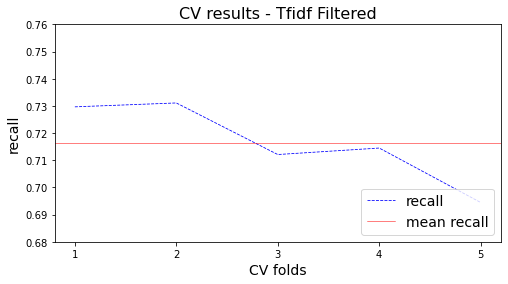

Elapsed time: 7.0937 seconds


In [29]:
plot_cvresults(NB_clf, X_filt_tfidf, y, 'Tfidf Filtered', scoring='recall', ylim=[.68,.76])

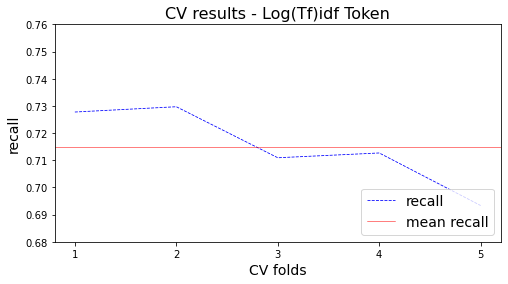

Elapsed time: 7.4022 seconds


In [30]:
plot_cvresults(NB_clf, X_tokn_tfidf, y, 'Log(Tf)idf Token', scoring='recall', ylim=[.68,.76])

Recall confirms the results of accuracies.

Looking at `precision`:

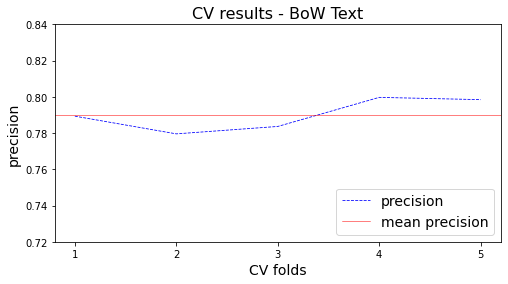

Elapsed time: 7.9019 seconds


In [31]:
plot_cvresults(NB_clf, X_text_bow, y, 'BoW Text', scoring='precision', ylim=[.72,.84])

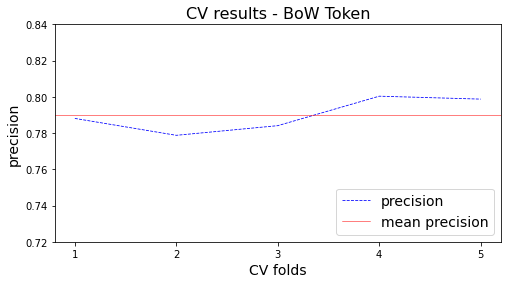

Elapsed time: 7.4090 seconds


In [32]:
plot_cvresults(NB_clf, X_tokn_bow, y, 'BoW Token', scoring='precision', ylim=[.72,.84])

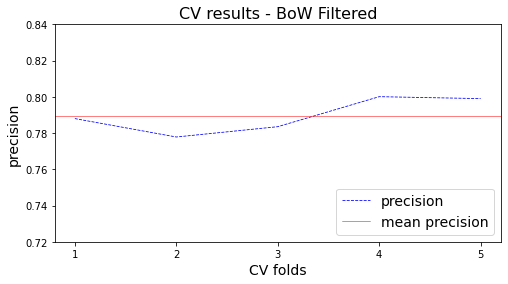

Elapsed time: 7.0107 seconds


In [33]:
plot_cvresults(NB_clf, X_filt_bow, y, 'BoW Filtered', scoring='precision', ylim=[.72,.84])

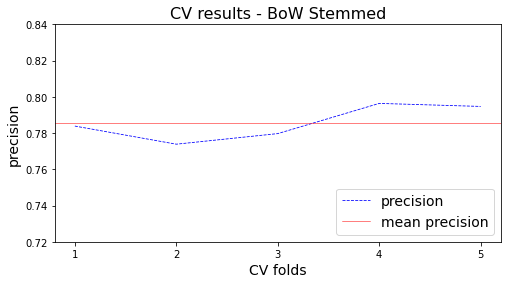

Elapsed time: 6.9387 seconds


In [34]:
plot_cvresults(NB_clf, X_stem_bow, y, 'BoW Stemmed', scoring='precision', ylim=[.72,.84])

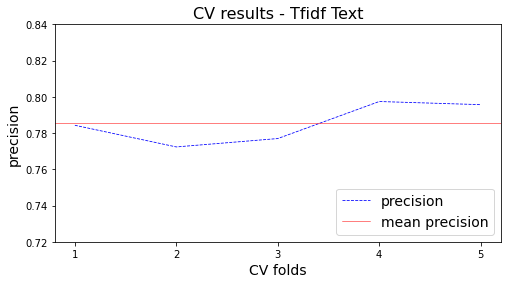

Elapsed time: 7.5247 seconds


In [35]:
plot_cvresults(NB_clf, X_text_tfidf, y, 'Tfidf Text', scoring='precision', ylim=[.72,.84])

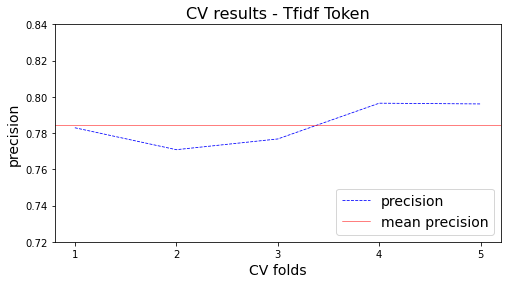

Elapsed time: 7.5985 seconds


In [36]:
plot_cvresults(NB_clf, X_tokn_tfidf, y, 'Tfidf Token', scoring='precision', ylim=[.72,.84])

Same. Final check, `auc`:

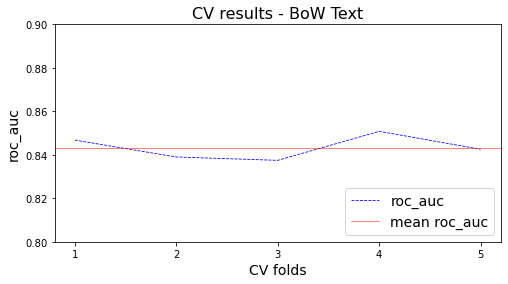

Elapsed time: 7.6914 seconds


In [37]:
plot_cvresults(NB_clf, X_text_bow, y, 'BoW Text', scoring='roc_auc', ylim=[.8,.9])

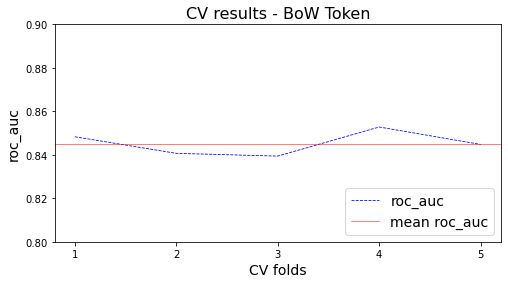

Elapsed time: 7.9271 seconds


In [38]:
plot_cvresults(NB_clf, X_tokn_bow, y, 'BoW Token', scoring='roc_auc', ylim=[.8,.9])

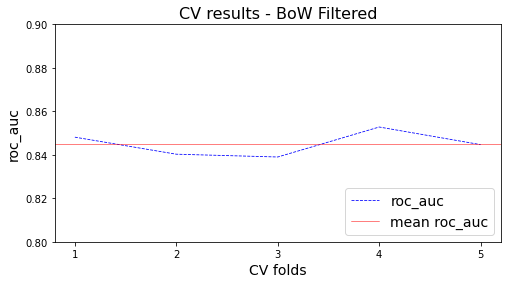

Elapsed time: 7.9247 seconds


In [39]:
plot_cvresults(NB_clf, X_filt_bow, y, 'BoW Filtered', scoring='roc_auc', ylim=[.8,.9])

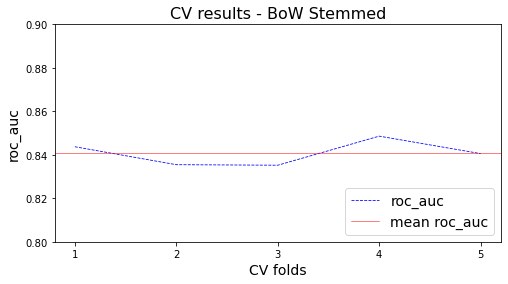

Elapsed time: 7.9120 seconds


In [40]:
plot_cvresults(NB_clf, X_stem_bow, y, 'BoW Stemmed', scoring='roc_auc', ylim=[.8,.9])

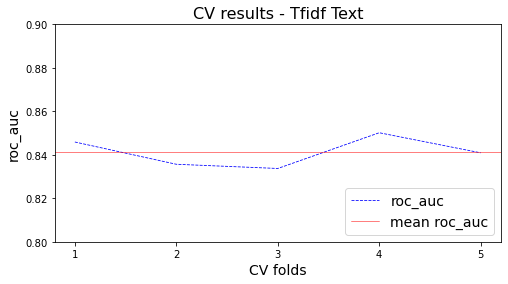

Elapsed time: 7.8799 seconds


In [41]:
plot_cvresults(NB_clf, X_text_tfidf, y, 'Tfidf Text', scoring='roc_auc', ylim=[.8,.9])

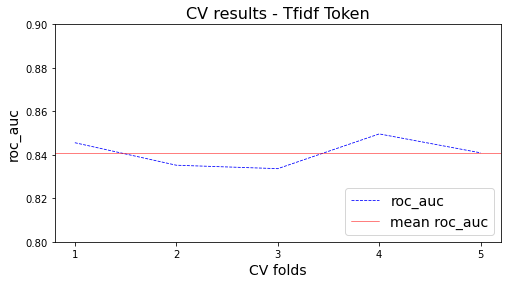

Elapsed time: 8.0541 seconds


In [42]:
plot_cvresults(NB_clf, X_tokn_tfidf, y, 'Tfidf Token', scoring='roc_auc', ylim=[.8,.9])

**Assessment**

For Naive Bayes, the BoW tokenized and filtered versions have the best qualities overall.

#### Tokenized BoW

In [43]:
# split full tokenized set 
X_train, X_test, y_train, y_test = \
train_test_split(X_tokn_bow, y, test_size=0.2, random_state=42)

In [44]:
y_scores = cross_val_predict(NB_clf, X_train, y_train, cv=5)

In [45]:
precisions, recalls, thresholds = precision_recall_curve(y_train, y_scores)

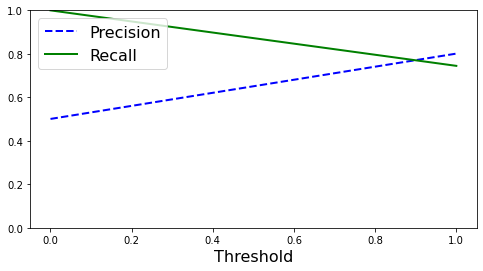

In [46]:
plt.figure(figsize=(8, 4))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

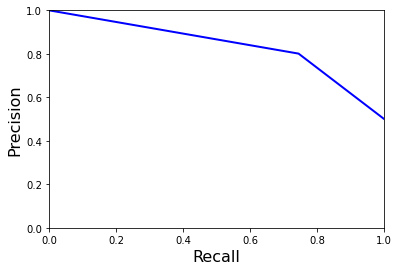

In [47]:
plt.figure(figsize=(6, 4))
plot_precision_vs_recall(precisions, recalls)
plt.show()

In [48]:
fpr, tpr, thresholds = roc_curve(y_train, y_scores)

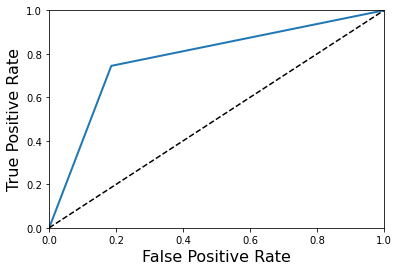

In [49]:
plt.figure(figsize=(6, 4))
plot_roc_curve(fpr, tpr)
plt.show()

####  Learning Curves


Since we have ~1,6M rows I'll only plot every 100k-th data point.

In [54]:
@timer
def plot_learning_curves(model, X, y):
    """Plot the learning curves for train and validation sets, given a model,
    a dataset X, and a target feature vector y.
    """
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
    train_acc, val_acc = [], []

    # plot every 100,000th data point
    data_granularity = 100000
    xs = []
    for m in range(1, X_train.shape[0], data_granularity):        
        model.fit(X_train[:m], y_train[:m])
        y_train_predict = model.predict(X_train[:m])
        y_val_predict = model.predict(X_val)
        train_acc.append(accuracy_score(y_train[:m], y_train_predict))
        val_acc.append(accuracy_score(y_val, y_val_predict))
        xs.append(str(m-1))

    fig = plt.figure(figsize=(12, 6))
    ax = fig.add_axes([0.0, round(X_train.shape[0]/data_granularity, 0), 0.6, 0.8])
    plt.plot(xs, np.sqrt(train_acc), 'r--', linewidth=.8, label="train accuracy")
    plt.plot(xs, np.sqrt(val_acc), 'b--', linewidth=.8, label="validation accuracy")
    plt.xticks(rotation=45)
    plt.title("Learning Rate During Training and Validation", fontsize=16)
    plt.legend(loc="lower right", fontsize=14)
    plt.xlabel("Training Set Size", fontsize=14)
    plt.ylabel("Accuracy", fontsize=14)
    plt.show()

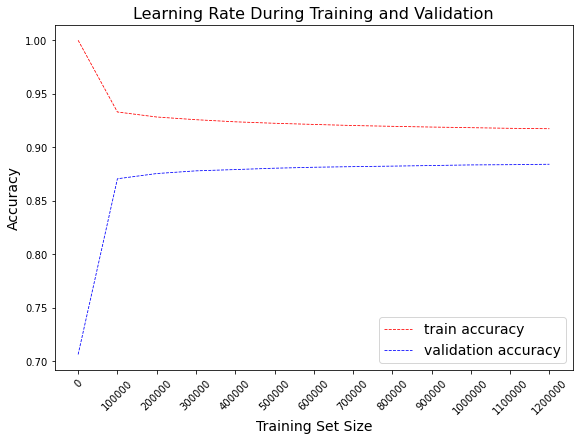

Elapsed time: 17.6826 seconds


In [56]:
plot_learning_curves(NB_clf, X_filt_bow, y)


- TODO: add graph interpretation

### Support Vector Machines

SVM classifiers are slow so we need to sample.


**5% Random Sample**

In [58]:
pct_ = round(X_filt_bow.shape[0]/20, 0)

ix = sample_without_replacement(n_population=X_filt_bow.shape[0],
                                n_samples=pct_, random_state=42)

X_filt_bow_sample = X_filt_bow[ix,]
y_sample = y[ix,]

# check that target class is balanced
sum(y_sample) / len(y_sample)

0.5014694607717863

In [59]:
# sanity checks
X_filt_bow_sample, len(y_sample)

(<78260x749718 sparse matrix of type '<class 'numpy.int64'>'
 	with 755878 stored elements in Compressed Sparse Row format>,
 78260)

In [60]:
# split sampled set 
X_train, X_test, y_train, y_test = \
train_test_split(X_filt_bow_sample, y_sample, test_size=0.2, random_state=42)

In [61]:
@timer
def train_SVC(X_train, y_train):

    svm_clf = SVC(gamma="auto") # research kernels!
    svm_clf.fit(X_train, y_train)

    return svm_clf

In [62]:
svm_clf = train_SVC(X_train, y_train)

Elapsed time: 936.4734 seconds


In [70]:
print(str(round(936.4734/60,2)), " mins.")

15.61  mins.


### Persist Model

Because it takes long to train, I'm keen on preserving it (prob best to do only if it's accurate?).

In [64]:
from pathlib import Path

# make dir if not exists, including parent dirs
dirpath = os.path.join("..","data","4_models","sentiment140")
Path(dirpath).mkdir(parents=True, exist_ok=True)

In [65]:
# save model 
now = str(int(time.time()))
filename = ''.join([now, "_svm_clf_filt_bow_5pctsample.joblib"])
filepath = os.path.join(dirpath, filename)

In [67]:
from joblib import dump, load
dump(svm_clf, filepath)

['..\\data\\4_models\\sentiment140\\1601239209_svm_clf_filt_bow_5pctsample.joblib']

In [68]:
# Predict the response for test dataset
y_pred = svm_clf.predict(X_test)

In [69]:
print("Accuracy:", accuracy_score(y_test, y_pred))

Accuracy: 0.4964221824686941


I wonder what accuracy NB would get with 5% of the data?

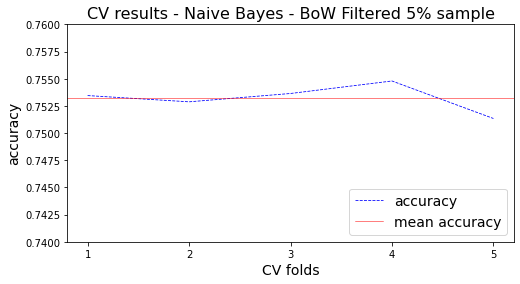

Elapsed time: 0.4579 seconds


In [76]:
plot_cvresults(NB_clf, X_filt_bow_sample, y_sample, 
               'Naive Bayes - BoW Filtered 5% sample', 
               scoring='accuracy', ylim=[.74,.76])

TODO: 
- what's the diff between SVM and SVC?
- why is SVC slow to train?
- what is the gamma kernel?
- is it better to use another kernel?
- train LR models
- train other models (bagging: random forests, boosting: adaboost, xgboost)

---